# Simulating an Atomic Bomb - An Exercise in Neutron Diffusion #

Evan Petrimoulx 

Dr. J. Rau

December 2024

PHYS-3600, Computation Physics Final Project

### Usual Imports: ###

In [12]:
import numba 
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, IntSlider

### Standard Diffusion ###

Diffusion is defined as "the spreading of something more widely". It is used to describe phenomena such as heat emission, solute and solvent interaction, and even the process of breathing. The phenomena can be described mathematically with the following relation: 

$$
    \frac{\partial \phi}{\partial t} = D \nabla^2 \phi
$$

Where $D$ is the diffusion constant. This value tells us how fast the particles are spreading apart or leaving the source. The left side of the equation tells us how the density of the diffusing material changes over time, and the right hand side tells us how the density of the diffusing material changes across space.

If $D$ is a constant throughout the diffusion process, the equation has analytical solutions and is identical to the *Heat Equation*. It has the following solutions in 1-Dimension (Using Dirichlet Boundary Conditions):

$$  
    \phi(x, t) = \sum_{k = 1}^\infty A_k \sin \left( \frac{k \pi x}{l} \right) e^{\frac{-D k^2 \pi^2 t}{l^2}} 
$$

Where $A_k$ is:

$$
    A_k = \frac{2}{l} \int_0^l \phi(x, 0) \sin \left( \frac{k \pi x}{l} \right)dx
$$

Each exponential converges to zero as $t \rightarrow \infty$, which means that $\phi(x, t)$ tends to equillibrium.

But it is important to note that this equation and its solutions only account for diffusing material. What if the material is diffusing, and the diffused material interacts with its surroundings, producing more diffusion? Will the system still reach an equillibrium? Or will it begin to grow exponentially instead?
 
This modified process is known as a **Diffusion-Reaction**. It is common in processes such as atomic bombs and nuclear reactors, where neutrons are diffusing from a fuel source and the produced neutrons interact and produce **more** neutrons. Modifying the standard diffusion equation to fit our neutron-reaction process is of key interest to this project, and will be used to analyze different fissile materials, looking at their energy output. The modified equation can be written as follows:

$$
    \frac{\partial \phi}{\partial t} = D \nabla^2 \phi + \eta \phi
$$

Where $\eta$ is the reaction rate of the system. This equation can be solved analytically, but is dependant on the boundary conditions of the problem and the reaction rate of the material being considered.

The general solution process will be to create an object of type "Material", and give it key information based on the fuel rod parameters. This will include things such as atomic number, size, and shape. We then insert the fuel rod into a 3D grid, and diffuse it with its reaction rate. Placing two fuel rods close to eachother allows them to interact with one another, and increase the amount of neutron production, leading to higher energy output. In the case of an atomic bomb explosion, the fuel rods should be smashed together. This will be done here by simulating the diffusion of two fuel rods at different separation distances, and finding when they explode.




We can start by defining constants for the grid size and diffusion. Right now DIFFUSION_CONST is the value corresponding to U$^{235}$:

In [4]:
BOX_LENGTH: int = 40
DIFFUSION_CONST: float = 2.34e5

Object class for the fuel rods

In [5]:
class Shape:
    """
    Note: the length, width, and height members are described in terms of # of Uranium atoms

    Ex. length = 5 means 5 Uranium atoms in length
    """
    def __init__(self, length: int, width: int, height: int, name: str, mass: int, element_name: str, element_num: int):
        self.name: str = name
        self.length: int = length
        self.width: int = width
        self.height: int = height
        self.mass: int = mass
        self.element: str = element_name
        self.element_num: int = element_num

    def __str__(self):
        return (f'Element: {self.element}-{self.mass}\n'
                f'Z: {self.element_num}\n'
                f'Shape: {self.name}\n'
                f'Length: {self.length}\n'
                f'Width: {self.width}\n'
                f'Height: {self.height}')

    def calc_num_neutrons(self):
        return self.mass - self.element_num

    def set_initial_conditions(self):
        initial_condition = np.zeros((self.length, self.width, self.height))

        if self.name == "Cylinder":
            cylinder_radius = 3  # Radius of the cylinder
            cylinder_center = (self.length // 2, self.width // 2)  # Center of the cylinder in the XY plane
            cylinder_axis = 'z'  # Axis of the cylinder ('x', 'y', or 'z')

            # Fill the cylinder within the cube
            for x in range(self.length):
                for y in range(self.width):
                    for z in range(self.height):
                        if cylinder_axis == 'z':  # Cylinder aligned along the z-axis
                            distance = np.sqrt((x - cylinder_center[0]) ** 2 + (y - cylinder_center[1]) ** 2)
                            if distance <= cylinder_radius and z < self.height:
                                initial_condition[x, y, z] = self.calc_num_neutrons()

        elif self.name == "Sphere":
            radius = 3
            x0, y0, z0 = int(np.floor(initial_condition.shape[0] / 2)), int(np.floor(initial_condition.shape[1] / 2)), int(np.floor(initial_condition.shape[2] / 2))
            for x in range(x0 - radius, x0 + radius + 1):
                for y in range(y0 - radius, y0 + radius + 1):
                    for z in range(z0 - radius, z0 + radius + 1):
                        ''' deb: measures how far a coordinate in A is far from the center. 
                                deb>=0: inside the sphere.
                                deb<0: outside the sphere.'''
                        deb = radius - abs(x0 - x) - abs(y0 - y) - abs(z0 - z)
                        if deb >= 0:
                            initial_condition[x, y, z] = self.calc_num_neutrons()

        elif self.name == "Triangular Prism":
            for x in range(0, self.length):
                for y in range(x, self.width):
                    for z in range(y, self.height):
                        initial_condition[x, y, z] = self.calc_num_neutrons()

        elif self.name == "Left Hemisphere":
            radius = 3
            x0, y0, z0 = int(np.floor(initial_condition.shape[0] / 2)), int(
                np.floor(initial_condition.shape[1] / 2)), int(np.floor(initial_condition.shape[2] / 2))
            for x in range(x0 - radius, x0 + radius + 1):
                for y in range(y0 - radius, y0 + radius + 1):
                    for z in range(z0 - radius, z0 + radius + 1):
                        ''' deb: measures how far a coordinate in A is far from the center. 
                                deb>=0: inside the sphere.
                                deb<0: outside the sphere.'''
                        deb = radius - abs(x0 - x) - abs(y0 - y) - abs(z0 - z)
                        if deb >= 0:
                            initial_condition[x, y, z] = self.calc_num_neutrons()
            initial_condition[:, :, self.height // 2:] = 0.0

        elif self.name == "Right Hemisphere":
            radius = 3
            x0, y0, z0 = int(np.floor(initial_condition.shape[0] / 2)), int(
                np.floor(initial_condition.shape[1] / 2)), int(np.floor(initial_condition.shape[2] / 2))
            for x in range(x0 - radius, x0 + radius + 1):
                for y in range(y0 - radius, y0 + radius + 1):
                    for z in range(z0 - radius, z0 + radius + 1):
                        ''' deb: measures how far a coordinate in A is far from the center. 
                                deb>=0: inside the sphere.
                                deb<0: outside the sphere.'''
                        deb = radius - abs(x0 - x) - abs(y0 - y) - abs(z0 - z)
                        if deb >= 0:
                            initial_condition[x, y, z] = self.calc_num_neutrons()

            initial_condition[:, :, :self.height // 2] = 0.0

        else:
            initial_condition.fill(self.calc_num_neutrons())

        return initial_condition

We will now build the 3D diffusion-reaction equation based on the 2D standard diffusion equation discussed in class. The function has arguments for the initial condition, which states the fuel rod positions and their starting neutron densities, the grid spacing, timestep, number of timesteps and boundary conditions for the edges of the simulation grid, which ensure neutrons do not escape. Additionally, I have designed the program to optionally take arguments for the diffusion constant, reaction rate, and boundary conditions.

In [6]:
@numba.njit
def diffusion_3d(
        init_condition: np.ndarray,
        grid_spacing: float,
        timestep: float,
        num_timesteps: int,
        boundary: np.ndarray,
        dirichlet_values: np.ndarray = None,
        boundary_type: str = 'dirichlet',
        diffusion_const: float = 2.34e5,
        reaction_rate: float = 1.896e8
) -> np.ndarray:
    """
    Simulates the 3D diffusion-reaction process over a grid with Dirichlet or Neumann boundary conditions.
    This function evolves the neutron density `n` over time according to the diffusion-reaction equation:
        ∂n/∂t = D ∇²n + \eta n
    where `D` is the diffusion constant, and `\eta` is the reaction rate constant.
    :param init_condition: Initial neutron density array (3D ndarray).
    :type init_condition: numpy.ndarray
    :param grid_spacing: Distance between grid points in the spatial domain.
    :type grid_spacing: float
    :param timestep: Time increment for each simulation step.
    :type timestep: float
    :param num_timesteps: Number of timesteps to simulate.
    :type num_timesteps: int
    :param boundary: Boolean 3D array marking boundary (`True`) and interior (`False`) points.
    :type boundary: numpy.ndarray
    :param dirichlet_values: Fixed concentration values at boundary points (for Dirichlet conditions).
                             If `None`, Neumann (no-flux) conditions are applied.
    :type dirichlet_values: numpy.ndarray, optional
    :param boundary_type: Type of boundary conditions.
    :type boundary_type: str
    :param diffusion_const: Diffusion constant `D`. Default is 2.34e5.
    :type diffusion_const: float, optional
    :param reaction_rate: Reaction rate constant `η`. Default is 1.896e8.
    :type reaction_rate: float, optional
    :return: 4D array of neutron density values over time with shape `(x, y, z, time)`.
    :rtype: numpy.ndarray
    :behavior:
      - Applies periodic boundaries with modular indexing.
      - Dirichlet boundary conditions are used if `dirichlet_values` is provided;
        otherwise, Neumann (no-flux) conditions are applied, keeping boundary values constant.
    :author: Evan Petrimoulx
    :date: November 4th 2024
    **Example usage:**
    .. code-block:: python
        nx, ny, nz = 10, 10, 10
        init_condition = np.random.rand(nx, ny, nz)
        boundary = np.zeros((nx, ny, nz), dtype=bool)
        boundary[:, 0, :] = boundary[:, -1, :] = True
        result = diffusion_3d(
            init_condition, boundary, grid_spacing=1.0, timestep=0.01, num_timesteps=100
        )
    """

    nx, ny, nz = init_condition.shape

    diffusion: np.ndarray = np.zeros((nx, ny, nz, num_timesteps), dtype=np.float64)
    d = diffusion_const * timestep / grid_spacing**2

    diffusion[:, :, :, 0] = np.copy(init_condition)

    for it in range(1, num_timesteps):
        for ix in range(0, nx):
            for iy in range(0, ny):     
                for iz in range(0, nz):
                    if not boundary[ix, iy, iz]:
                        diffusion[ix, iy, iz, it] = (diffusion[ix, iy, iz, it - 1] + 0.25 * d * (
                                diffusion[(ix + 1) % nx, iy, iz, it - 1] +
                                diffusion[(ix - 1) % nx, iy, iz, it - 1] +
                                diffusion[ix, (iy + 1) % ny, iz, it - 1] +
                                diffusion[ix, (iy - 1) % ny, iz, it - 1] +
                                diffusion[ix, iy, (iz + 1) % nz, it - 1] +
                                diffusion[ix, iy, (iz - 1) % nz, it - 1] - 6 * diffusion[ix, iy, iz, it - 1]) +
                                reaction_rate * diffusion[ix, iy, iz, it - 1] * timestep)
                    else:
                        # Neumann Boundary Conditions
                        if boundary_type == 'neumann':
                            diffusion[ix, iy, iz, it] = diffusion[ix, iy, iz, it - 1]

                        # Dirichlet Boundary Conditions
                        elif boundary_type == 'dirichlet' and dirichlet_values is not None:
                            diffusion[ix, iy, iz, it] = dirichlet_values[ix, iy, iz]

                        else:
                            # Robin Boundary Conditions Here
                            diffusion[ix, iy, iz, it] = diffusion[ix, iy, iz, it - 1]
    return diffusion

<>:23: SyntaxWarning: invalid escape sequence '\e'
<>:23: SyntaxWarning: invalid escape sequence '\e'
/var/folders/5q/zqbfj7115f94w3z03mhy8y5r0000gn/T/ipykernel_71109/3106298912.py:23: SyntaxWarning: invalid escape sequence '\e'
  """


Graphing routines:

In [7]:
def plot_fuel_rod_positions(array):
    # Get coordinates where the array is True
    x, y, z = np.where(array != 0)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Clear previous plot data
    ax.cla()

    # Plot the cubes as red points
    ax.scatter(x, y, z, c='r', marker='o')

    # Set limits for axes based on the grid size
    ax.set_xlim([0, array.shape[0] - 1])
    ax.set_ylim([0, array.shape[1] - 1])
    ax.set_zlim([0, array.shape[2] - 1])

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Fuel Rod Positions')

    # Optionally add a grid for better spatial orientation
    ax.grid(True)
    plt.show()

Placing fuel rods into the grid for calculation:

In [9]:
def place_fuel_rods_in_grid(grid: np.ndarray[float], rod1_initial_condition: np.ndarray[float], rod2_initial_condition: np.ndarray[float ], separation: float) -> np.ndarray[float]:
    """
    Takes the initial conditions set up from the individual fuel rods and places them into the simulation grid at a
    specified separation from one another

    :param grid: The Simulation grid
    :type grid: np.ndarray[float]
    :param rod1_initial_condition: The first fuel rod initial conditions (initial neutron density)
    :type rod1_initial_condition: np.ndarray
    :type rod2_initial_condition: np.ndarray
    :param rod2_initial_condition: The second fuel rod initial conditions (initial neutron density)
    :param separation: The separation between the fuel rods and the initial conditions
    :type separation: float
    """

    # Get the size of the larger and smaller arrays
    larger_size = grid.shape
    smaller_size1 = rod1_initial_condition.shape
    smaller_size2 = rod2_initial_condition.shape

    # Calculate the center of the larger array
    center_larger_x, center_larger_y, center_larger_z = larger_size[0] // 2, larger_size[1] // 2, larger_size[2] // 2

    # Calculate the starting indices for placing the smaller first array
    start_x = center_larger_x - smaller_size1[0] // 2 + separation //2
    start_y = center_larger_y - smaller_size1[1] // 2
    start_z = center_larger_z - smaller_size1[2] // 2

    # Place the smaller array inside the larger one
    grid[start_x:start_x + smaller_size1[0], start_y:start_y + smaller_size1[1], start_z:start_z + smaller_size1[2]] = rod1_initial_condition

    # Calculate the starting indices for placing the second smaller array
    start_x = center_larger_x - smaller_size1[0] // 2 - separation//2
    start_y = center_larger_y - smaller_size1[1] // 2
    start_z = center_larger_z - smaller_size1[2] // 2

    grid[start_x:start_x + smaller_size2[0], start_y:start_y + smaller_size2[1],start_z:start_z + smaller_size2[2]] = rod1_initial_condition

    return grid

A simple function to calculate the growth rate of neutrons in the system is also helpful in order to test criticality.

In [ ]:
def growth_rate(total_density: np.ndarray) -> np.ndarray:
    """
    Determines the growth rate of neutrons in the diffusion process. If the Neutron Multiplication factor (k) is
        equal to 1, The reaction is critical. If k is less than 1 the reaction is Sub-critical, and if k is greater than 1 the
        reaction is Supercritical

    :param total_density:
    :type: np.ndarray

    :return: average neutron multiplication factor
    :rtype np.ndarray

    :author: Evan Petrimoulx
    :date: November 5th 2024
    """
    k_effective = np.zeros(len(total_density))
    for i in range(1, len(total_density) - 1):
        k_effective[i+1] =  total_density[i+1] / total_density[i]

    return k_effective

def determine_k(k) -> None:
    if k > 1:
        print(f'The reaction has gone super-critical!')
    elif k == 1:
        print(f'The reaction has gone critical!')
    else:
        print(f'The reaction is sub-critical!')

Element: Uranium-235
Z: 92
Shape: Sphere
Length: 8
Width: 8
Height: 8 

Element: Uranium-235
Z: 92
Shape: Sphere
Length: 8
Width: 8
Height: 8 



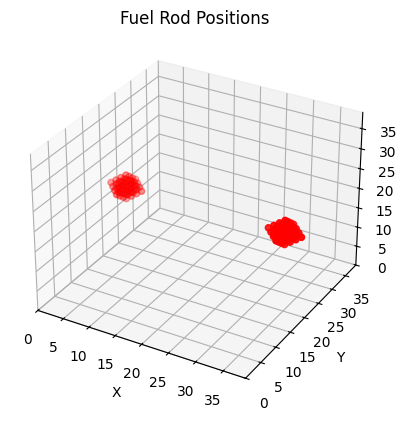

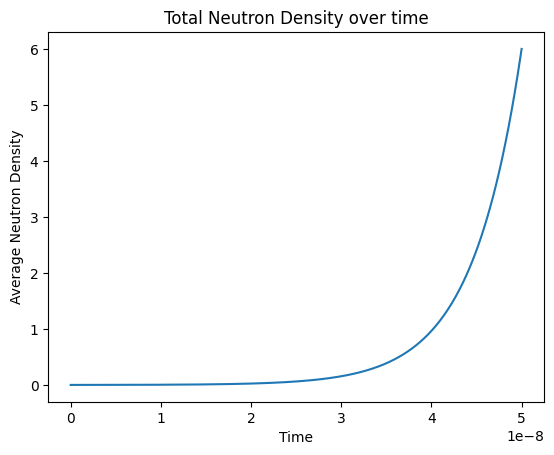

interactive(children=(IntSlider(value=0, description='Time Step', max=448), Output()), _dom_classes=('widget-i…

In [14]:
def main():
    # Create Fuel Rod Objects
    fuel_rod_1 = Shape(8, 8, 8, 'Sphere', 235, 'Uranium', 92)
    fuel_rod_2 = Shape(8, 8, 8, 'Sphere', 235, 'Uranium', 92)

    print(f'{fuel_rod_1} \n')
    print(f'{fuel_rod_2} \n')

    # Set up initial conditions for both Fuel Rod Objects
    initial_condition_1 = fuel_rod_1.set_initial_conditions()
    initial_condition_2 = fuel_rod_2.set_initial_conditions()

    # Initialize grid-spacing, timesteps, number of timesteps, total time, and density
    grid_spacing: float       = 1 / BOX_LENGTH
    timestep_size: float      = (grid_spacing ** 2 / 6 / DIFFUSION_CONST) * 0.25
    t_final: float            = 5e-8
    num_timesteps: int        = int(t_final / timestep_size)
    total_density: np.ndarray = np.zeros(num_timesteps)
    time: np.ndarray          = np.linspace(0, t_final, num_timesteps)

    # Create Grid
    grid = np.zeros((BOX_LENGTH, BOX_LENGTH, BOX_LENGTH))
    boundary_grid = np.full((BOX_LENGTH, BOX_LENGTH, BOX_LENGTH), False)
    boundary_grid[-1, :, :] = True
    boundary_grid[:, -1, :] = True
    boundary_grid[0, :, :] = True
    boundary_grid[:, 0, :] = True

    object_separation = 30

    # Embed fuel rods into the grid
    grid = place_fuel_rods_in_grid(grid, initial_condition_1, initial_condition_2, object_separation)


    # Plot the fuel rod starting positions
    plot_fuel_rod_positions(grid)

    # Diffuse
    result = diffusion_3d(grid, grid_spacing, timestep_size, num_timesteps, boundary_grid)

    # Check for nan's
    if np.isnan(result).any():
        print(f'The reaction went super critical and an overflow occurred. Stopping the simulation.')
        exit()
        
    # Calculate density
    for i in range(0, num_timesteps):
        total_density[i] = np.sum(result[:, :, :, i]) / result.size

    plt.figure()
    plt.title(f'Total Neutron Density over time')
    plt.xlabel('Time')
    plt.ylabel('Average Neutron Density')
    plt.plot(time, total_density)
    plt.show()
    
    def plot_diffusion(time_step):
        """Plot a 2D slice of the 3D diffusion result at a specific time step."""
        plt.figure(figsize=(8, 6))
        plt.imshow(
            np.transpose(result[:, BOX_LENGTH // 2, :, time_step]),
            cmap='coolwarm',
            origin='lower',
            vmin=0.0
        )
        plt.contour(
            np.transpose(result[:, BOX_LENGTH // 2, :, time_step]),
            levels=30,
            linewidths=0.5,
            colors='k',
            alpha=0.5
        )
        plt.colorbar(fraction=0.02)
        plt.title(f"Diffusion at step {time_step}")
        plt.xlabel("X-axis")
        plt.ylabel("Z-axis")
        plt.show()

    # Create the slider widget for time step
    time_slider = IntSlider(
        value=0,  # Initial value
        min=0,  # Minimum time step
        max=result.shape[3] - 1,  # Maximum time step
        step=1,  # Increment step
        description='Time Step'
    )

    # Use the interact function to link the slider to the plot function
    interact(plot_diffusion, time_step=time_slider)



if __name__ == '__main__':
    main()